In [1]:
import pickle 
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from IPython.display import display, Latex


In [2]:
d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu'],
    '4': ['Nb', 'Mo', ],
    '5': ['W', ]
}

# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ir": "b",
    "Ni": "#66FF00",
}

In [18]:
def plot_parabola(parabola):
    x = np.linspace(0, 4, 10)
    y = parabola[0]*x**2+parabola[1]*x
    plt.plot(x, y)
    
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = mp_quadratic_equations_ox[ele1]
    ox_quadratic_2 = mp_quadratic_equations_ox[ele2]
    red_quadratic_1 = mp_quadratic_equations_red[ele2]
    red_quadratic_2 = mp_quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    minima = []
    x_tots = []
    for conc in concentrations:
        
        o_1a, o_2a, o_3a = ox_quadratic_1
        r_1a, r_2a, r_3a = red_quadratic_1

        o_1b, o_2b, o_3b = ox_quadratic_2
        r_1b, r_2b, r_3b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a, True), bounds=[(0, 10)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b, True), bounds=[(0, 10)])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a),  bounds=[(0, 10)])
            # Note, the definition of concentration is different  between 1/2,
            # since it relates to the concentration of the element that is 
            # oxidisint or reducing.
            #handle this when plotting by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b),  bounds=[(0, 10)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        # this can give problems depending on scipy version, might have to use result_1.fun
        predicted_forms_1.append(result_1.fun)
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun)#result_2.fun[0] + diff*(1-conc))
        
        if plotting:
            mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
            ox1 = o_1a*x_space**2+o_2a*x_space
            red1 = r_1a*x_space**2+r_2a*x_space
            mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
            ox2 = o_1b*x_space**2+o_2b*x_space
            red2 = r_1b*x_space**2+r_2b*x_space

            if min(mixed_1)<min(mixed_2):
                minima.append(min(mixed_1))
                x_tots.append(result_1.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_1, label='mixed_{}{:.1f}{}{:.1f}'.format(ele1, 1-conc, ele2, conc), color='gray')
                    plt.plot(result_1.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox1, label=ele1+"_ox", color=ele2col[ele1[:-1]])
                    plt.plot(x_space, red1, label=ele2+"_red", color=ele2col[ele2[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
            else:
                minima.append(min(mixed_2))
                x_tots.append(result_2.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_2, label='mixed_{}{:.2f}{}{:.2f}'.format(ele1, 1-conc, ele2, conc), )#color='gray')
                    plt.plot(result_2.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox2, label=ele2+"_ox", color=ele2col[ele2[:-1]])
                    plt.plot(x_space, red2, label=ele1+"_red", color=ele2col[ele1[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.legend()
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
    
    if plotting:
        print("X_tots")
        for x in x_tots:
            print("{:.2f}".format(x), end=", ")
        print("\nΔ Cs")
        for x in minima:
            print("{:.2f}".format(x), end=", ")
        plt.plot(concentrations, minima)
        plt.plot([0, 1], [minima[0], minima[-1]], 'k--')
        plt.legend(fontsize=13)
        plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
        plt.yticks(fontsize=13)
        
        plt.savefig("deltaC_1c.pdf")
        plt.show()

        ox2 = o_1b*x_space**2+o_2b*x_space
        red2 = r_1b*x_space**2+r_2b*x_space
        plt.plot(x_space, ox2, label=ele2[:-1], color=ele2col[ele2[:-1]])
        plt.plot(x_space, red2, label=ele1[:-1], color=ele2col[ele1[:-1]])
        plt.ylim(top=1)
        plt.legend(fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.savefig("indiv_parabolas_1a.pdf")
        plt.show()
        
    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, r1, r2, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))


def find_nearest(array, value):
    """
    Helper function to find the closest conc
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


In [19]:
mp_quadratic_equations_ox = pickle.load(open('make_quadratics/mp_quadratic_equations_ox.p', 'rb'))
mp_quadratic_equations_red = pickle.load(open('make_quadratics/mp_quadratic_equations_red.p', 'rb'))

binary_pairing_data = pickle.load(open('data_gather/binary_pairing_data.p', 'rb'))

# iterate over these eqs, removing the oxidation number label to get all the elements 
set_of_elements = set([x[:-1] for x in mp_quadratic_equations_ox])
# these give issues in that they cause a bug where the code finds or Ir Yb entries 
# when it shouldn't. I gets mistakenly matched with Ir data, and Y with Yb data.
set_of_elements.remove("I")
set_of_elements.remove("Y")


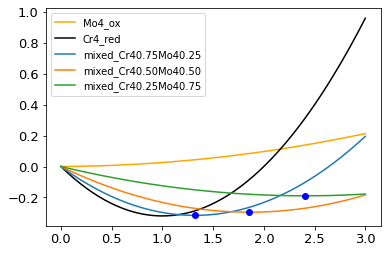

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


X_tots
1.00, 1.32, 1.86, 2.41, 0.00, 
Δ Cs
-0.32, -0.32, -0.29, -0.19, 0.00, 

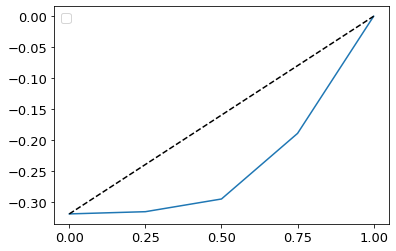

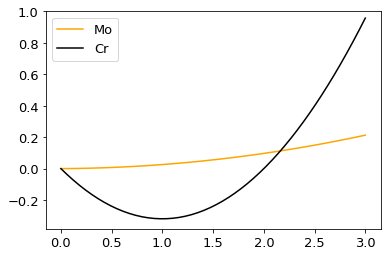

[ 0.         -0.07615851 -0.1353415  -0.10922352  0.        ]


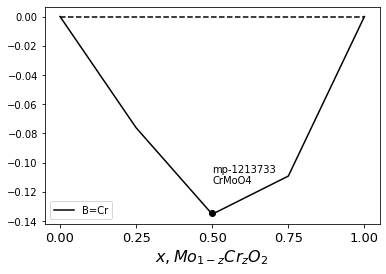

In [21]:
oxidation_state = 4
for housing_element in ['Mo']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = [0, 0.25, 0.5, 0.75, 1.0]

    for ele in ['Cr']:

        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, plotting=True)

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            print(pred_1)
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
            print(pred_2)
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])

                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                        
    plt.xticks([0, 0.25, 0.5, 0.75, 1], fontsize=13)
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}Cr_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.savefig("Cr_Mo_1d.pdf")
        

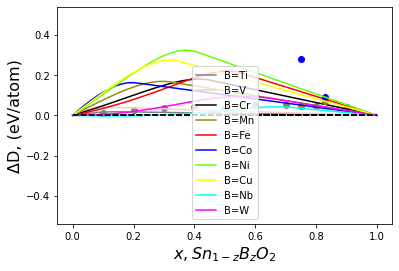

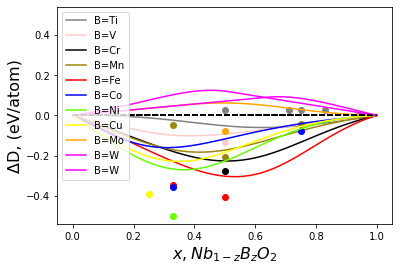

In [6]:
oxidation_state = 4
for housing_element in ['Sn', 'Nb']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = np.linspace(0, 1.00, 51)

    for ele in d2metals['3']+d2metals['4']+d2metals['5']:
        #print(ele)
        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])

        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}B_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("ΔD, (eV/atom)", fontsize=16)
    plt.ylim(-0.54, 0.54)
    plt.savefig("{}_higherdmixing.pdf".format(housing_element))
    plt.show()
        
        

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 777
MAE for unfiltered: 0.236
total matches with good geom: 232
MAE for filtered: 0.127


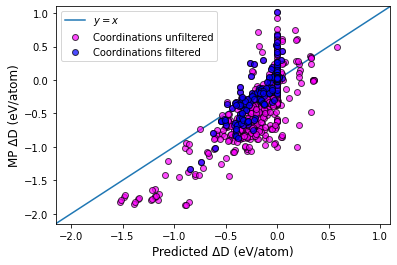

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 1369
MAE for unfiltered: 0.248
total matches with good geom: 176
MAE for filtered: 0.118


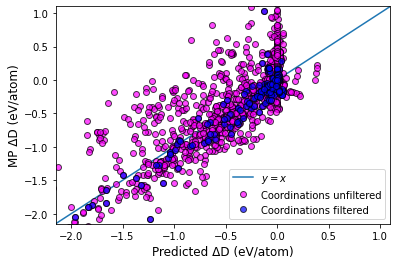

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 932
MAE for unfiltered: 0.122
total matches with good geom: 298
MAE for filtered: 0.096


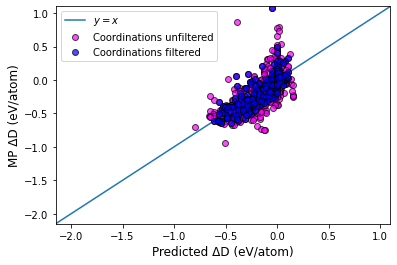

In [7]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
maes = []
num_oxides = []

good_maes = []
num_good_oxides = []
# dictionary mapping oxidation state to x/y plot for all oxides 
ox2xs = defaultdict()
ox2ys = defaultdict()
# dictionary mapping oxidation state to x/y plot for oxides conditioned on geometry
ox2good_xs = defaultdict()
ox2good_ys = defaultdict()

# dictionary mapping oxidation state to form ene x/y plot for all oxides 
ox2pred_form_enes = defaultdict()
ox2mp_form_enes = defaultdict()
ox2weighted_avgs = defaultdict()
# dictionary mapping oxidation state to form ene x/y plot for oxides conditioned on geometry
ox2good_pred_form_enes = defaultdict()
ox2good_mp_form_enes = defaultdict()
ox2good_weighted_avgs = defaultdict()


for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []
    lower_lim = -2.15
    upper_lim = 1.1
    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                
    plt.plot([lower_lim, upper_lim], [lower_lim, upper_lim], label='$y=x$')
    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
    print("total matches: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='fuchsia', alpha=0.7, label='Coordinations unfiltered', markeredgecolor='k')
    print("MAE for unfiltered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_oxides.append(len(xs))
    ox2xs[oxidation_state] = xs
    ox2ys[oxidation_state] = ys
    ox2pred_form_enes[oxidation_state] = pred_form_enes
    ox2mp_form_enes[oxidation_state] = mp_form_enes
    ox2weighted_avgs[oxidation_state] = weighted_avgs

    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        if not val['coordination_match']:
            # bad geometry, skip
            continue
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
#         if abs(xs[-1]-ys[-1])>0.5:
#             plt.text(xs[-1], ys[-1], "{}".format(key))

    ox2good_xs[oxidation_state] = xs
    ox2good_ys[oxidation_state] = ys
    ox2good_pred_form_enes[oxidation_state] = pred_form_enes
    ox2good_mp_form_enes[oxidation_state] = mp_form_enes
    ox2good_weighted_avgs[oxidation_state] = weighted_avgs
    print("total matches with good geom: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='b', alpha=0.7, label='Coordinations filtered', markeredgecolor='k')
    print("MAE for filtered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlim(lower_lim, upper_lim)
    plt.ylim(lower_lim, upper_lim)
    plt.legend()
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    plt.savefig("parities_ox_state_{}.pdf".format(oxidation_state))
    plt.show()
    good_maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_good_oxides.append(len(xs))


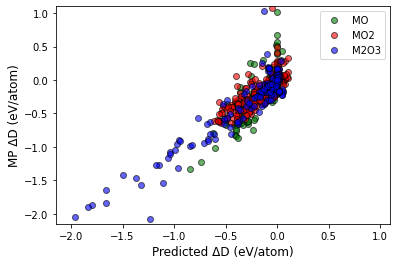

In [8]:
plt.plot(ox2good_xs[2], ox2good_ys[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
plt.plot(ox2good_xs[4], ox2good_ys[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
plt.plot(ox2good_xs[3], ox2good_ys[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
plt.xlim(lower_lim, upper_lim)
plt.ylim(lower_lim, upper_lim)
plt.legend()
plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
plt.savefig("parity_filtered_all.pdf")


Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

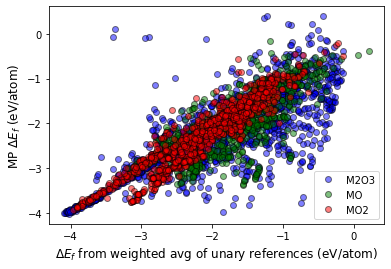

In [9]:
plt.plot(ox2weighted_avgs[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2weighted_avgs[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2weighted_avgs[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

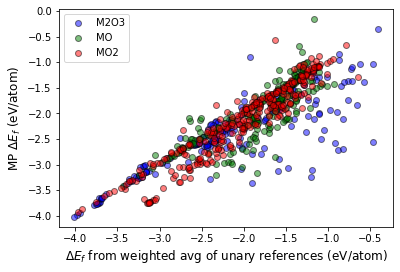

In [10]:
plt.plot(ox2good_weighted_avgs[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

MAE for M2O3: 0.248
MAE for MO: 0.236
MAE for MO2: 0.122


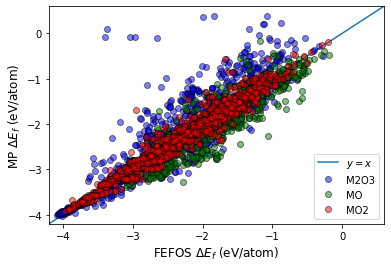

In [11]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2pred_form_enes[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
print("MAE for M2O3: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[3])-np.array(ox2mp_form_enes[3])))))
plt.plot(ox2pred_form_enes[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
print("MAE for MO: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[2])-np.array(ox2mp_form_enes[2])))))
plt.plot(ox2pred_form_enes[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
print("MAE for MO2: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[4])-np.array(ox2mp_form_enes[4])))))
plt.xlim(-4.2, 0.6)
plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_no_filter.pdf")

MAE for MO-type: 0.127
MAE for MO2-type: 0.096
MAE for M2O3-type: 0.118


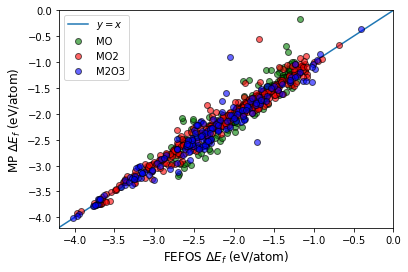

In [12]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2good_pred_form_enes[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
print("MAE for MO-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[2])-np.array(ox2good_mp_form_enes[2])))))
plt.plot(ox2good_pred_form_enes[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
print("MAE for MO2-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[4])-np.array(ox2good_mp_form_enes[4])))))
plt.plot(ox2good_pred_form_enes[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
print("MAE for M2O3-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[3])-np.array(ox2good_mp_form_enes[3])))))
plt.xlim(-4.2, 0.0)
plt.ylim(-4.2, 0.0)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_filter.pdf")


In [13]:
total_oxides = sum(num_oxides)
unfiltered_avg = 0
for num_ox, mae in zip(num_oxides, maes):
    unfiltered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for unfiltered: {:.3f} eV/atom".format(unfiltered_avg))
total_oxides = sum(num_good_oxides)
filtered_avg = 0
for num_ox, mae in zip(num_good_oxides, good_maes):
    filtered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for filtered: {:.3f} eV/atom".format(filtered_avg))


Total MAE for unfiltered: 0.207 eV/atom
Total MAE for filtered: 0.111 eV/atom


### Printing for spreadsheet

In [14]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []

    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                print(data_dict[inner_key]['mp_name'], end=", ")
                print(data_dict[inner_key]['mp_id'], end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['weighted average of refs']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['x_tot']), end=", ")
                print(data_dict[inner_key]['coordination_match'], end=", ")
                motifs2print = ""
                for motif in data_dict[inner_key]['motifs']:
                    motifs2print+=motif+"/"
                motifs2print = motifs2print[:-1]
                print(motifs2print)




Checking oxides of type as below


<IPython.core.display.Latex object>

GaAuO2, mp-11021, -1.5053, -1.1355, -0.7374, -0.3675, -0.7680, 1.9139, False, unrecognized/octahedral
LiGaO2, mp-5854, -2.3779, -2.1643, -0.8059, -0.5924, -1.5720, 2.0000, False, tetrahedral
GaHgO2, mp-1178231, -1.4679, -1.1626, -0.4575, -0.1522, -1.0104, 1.6397, False, unrecognized/octahedral
KGaO2, mp-4066, -2.1917, -1.7305, -0.7971, -0.3359, -1.3946, 1.5081, False, unrecognized/tetrahedral
CsGaO2, mp-1213401, -2.1001, -1.6986, -0.7380, -0.3365, -1.3621, 1.5262, False, unrecognized/tetrahedral
GaPtO2, mp-1178276, -1.5353, -1.1579, -0.5517, -0.1744, -0.9836, 1.6700, False, unrecognized/octahedral
GaCuO2, mp-11019, -1.6740, -1.1966, -0.5112, -0.0338, -1.1628, 1.4673, False, unrecognized/octahedral
NaGaO2, mp-3338, -2.2230, -1.8562, -0.8198, -0.4529, -1.4033, 2.0000, False, tetrahedral
GaAgO2, mp-11020, -1.5839, -1.1478, -0.6700, -0.2339, -0.9139, 1.7488, False, unrecognized/octahedral
TlGaO2, mp-14222, -1.6058, -0.9226, -0.6960, -0.0127, -0.9099, 1.4344, False, unrecognized/tetrahedral

RbCoO2, mp-1147736, -1.3115, -1.3169, 0.0017, -0.0038, -1.3131, 0.4165, False, unrecognized/tetrahedral
Rb2CoO3, mp-1278131, -1.4628, -1.3220, -0.1398, 0.0011, -1.3231, 0.4088, False, unrecognized
MgCoO2, mvc-15159, -2.0051, -2.1686, 0.1635, 0.0000, -2.1686, 0.0000, True, octahedral
Mg3CoO4, mp-1099254, -2.4931, -2.6112, 0.1181, 0.0000, -2.6112, 0.0000, True, octahedral
LiZnO2, mp-760408, -1.6398, -1.7751, 0.1353, 0.0000, -1.7751, 0.0000, True, octahedral
Zn3CdO4, mp-1215562, -1.6486, -1.6855, 0.0369, 0.0000, -1.6855, 0.0000, False, tetrahedral
ZnCdO2, mp-1215505, -1.5272, -1.5810, 0.0538, 0.0000, -1.5810, 0.0000, False, tetrahedral
ZnFeO2, mvc-2921, -1.5040, -1.6354, 0.1315, 0.0000, -1.6354, 0.0000, False, unrecognized
ZnCrO2, mvc-12575, -1.7345, -1.8780, 0.1436, 0.0000, -1.8780, 0.0000, False, square pyramidal/unrecognized/octahedral
CaZnO2, mp-1227007, -2.4117, -2.5489, 0.1372, 0.0000, -2.5489, 0.0000, False, tetrahedral
ZnPt3O4, mp-1207390, -0.7643, -0.8850, 0.1207, 0.0000, -0.8850

AgBrO2, mp-997047, -0.4681, -0.1829, -0.5348, -0.2496, 0.0667, 1.8849, False, unrecognized
Bi3BrO4, mp-866311, -1.5637, -0.9312, -1.0456, -0.4131, -0.5182, 1.6159, False, bcc/unrecognized
Mn2BrO3, mp-1190924, -1.5103, -1.3746, -0.3839, -0.2482, -1.1264, 1.5026, False, unrecognized
Li3RuO4, mp-37692, -1.8925, -1.8704, -0.3904, -0.3683, -1.5022, 2.8487, True, octahedral
LiRuO2, mp-28254, -1.5665, -1.6452, -0.3223, -0.4011, -1.2442, 2.7541, True, octahedral
Li2RuO3, mp-4630, -1.8369, -1.8529, -0.4207, -0.4368, -1.4162, 2.9904, True, octahedral
KRuO2, mp-1211539, -1.1140, -1.0958, -0.0472, -0.0290, -1.0668, 1.5339, False, unrecognized
NaRuO2, mp-7240, -1.4190, -1.4310, -0.3436, -0.3555, -1.0755, 3.7866, True, octahedral
Na2RuO3, mp-37255, -1.6296, -1.4390, -0.4384, -0.2477, -1.1912, 2.9459, False, octahedral
Na3RuO4, mp-1198628, -1.6586, -1.4375, -0.4095, -0.1884, -1.2491, 2.6496, False, unrecognized/octahedral
Ag3RuO4, mp-510453, -0.7127, -0.5564, -0.1975, -0.0413, -0.5151, 2.3781, False,

CdPd3O4, mp-13675, -0.9323, -0.9359, 0.0036, 0.0000, -0.9359, 0.0000, False, bcc/unrecognized
CdPd2O3, mp-1232324, -0.5087, -0.9843, 0.4756, 0.0000, -0.9843, 0.0000, False, unrecognized/octahedral
KPd2O3, mp-1095520, -1.1388, -0.9968, -0.1434, -0.0013, -0.9955, 0.4430, False, unrecognized/octahedral
CrPdO2, mp-1063607, -1.6853, -1.3783, -0.3070, 0.0000, -1.3783, 0.0000, False, unrecognized/octahedral
PdPbO2, mp-22367, -1.1494, -1.1293, -0.0201, 0.0000, -1.1293, 0.0000, False, unrecognized
CaPd3O4, mp-3315, -1.5154, -1.4198, -0.0956, 0.0000, -1.4198, 0.0000, False, bcc/unrecognized
CuPdO2, mp-997012, -0.8839, -0.8661, -0.0178, 0.0000, -0.8661, 0.0000, False, unrecognized
Na2PdO3, mp-685478, -1.3625, -1.2120, -0.1505, 0.0000, -1.2120, 0.0000, True, octahedral
NaPdO2, mp-755378, -1.1810, -1.1066, -0.0744, 0.0000, -1.1066, 0.0000, True, unrecognized/octahedral
NaPd3O4, mp-13285, -1.0803, -0.9486, -0.1317, 0.0000, -0.9486, 0.0000, False, bcc/unrecognized
AgPdO2, mp-997038, -0.6612, -0.6173,

Li2GeO3, mp-15349, -2.3220, -2.0558, -0.8023, -0.5361, -1.5197, 2.9787, False, unrecognized/tetrahedral
Li3GeO4, mp-1211318, -2.0846, -2.0492, -0.5048, -0.4694, -1.5798, 2.8457, False, unrecognized/tetrahedral
LiTbO2, mp-7137, -3.2707, -3.0216, -1.7269, -1.4778, -1.5438, 2.0000, False, unrecognized/octahedral
LiNi2O3, mp-757063, -1.4019, -1.3982, -0.0037, 0.0000, -1.3982, 0.0000, True, unrecognized/octahedral
LiNiO2, mp-865631, -1.4962, -1.4887, -0.0075, 0.0000, -1.4887, 0.0000, True, unrecognized/octahedral
Li2NiO3, mp-556550, -1.5841, -1.5792, -0.0049, 0.0000, -1.5792, 0.0000, True, octahedral
Li3Ni5O8, mp-758143, -1.4209, -1.4208, -0.0001, 0.0000, -1.4208, 0.0000, True, octahedral
Li13Ni15O28, mp-766878, -1.4724, -1.4693, -0.0031, 0.0000, -1.4693, 0.0000, True, square pyramidal/octahedral
Li7Ni5O12, mp-755638, -1.5334, -1.5339, 0.0006, 0.0000, -1.5339, 0.0000, True, square pyramidal/octahedral
Li13Ni9O22, mp-769473, -1.5361, -1.5380, 0.0019, 0.0000, -1.5380, 0.0000, True, square pyr

CdAgO2, mp-996963, -0.8838, -0.9081, 0.0243, 0.0000, -0.9081, 0.0000, False, unrecognized/octahedral
CdNiO2, mp-1226706, -1.1136, -1.2946, 0.1810, 0.0000, -1.2946, 0.0000, True, octahedral
BaCdO2, mp-7899, -2.1491, -2.0973, -0.0518, 0.0000, -2.0973, 0.0000, False, unrecognized
MnCdO2, mp-1221645, -1.6603, -1.6752, 0.0149, 0.0000, -1.6752, 0.0000, True, octahedral
Mn4CdO5, mp-1221716, -1.8137, -1.8571, 0.0434, 0.0000, -1.8571, 0.0000, True, octahedral
Mn9CdO10, mp-756679, -1.8839, -1.9177, 0.0339, 0.0000, -1.9177, 0.0000, True, octahedral
Mn2CdO3, mp-1221887, -1.7528, -1.7762, 0.0234, 0.0000, -1.7762, 0.0000, True, octahedral
MnCd9O10, mp-757244, -1.4258, -1.4327, 0.0069, 0.0000, -1.4327, 0.0000, True, octahedral
MnCd4O5, mp-1221762, -1.4843, -1.4933, 0.0090, 0.0000, -1.4933, 0.0000, True, octahedral
Mn2Cd3O5, mp-760391, -1.5905, -1.6146, 0.0240, 0.0000, -1.6146, 0.0000, True, octahedral
Mg3CdO4, mp-1099255, -2.5048, -2.6333, 0.1285, 0.0000, -2.6333, 0.0000, True, octahedral
Na5OsO6, mp

CrCuO2, mp-510625, -1.7838, -1.4539, -0.3299, 0.0000, -1.4539, 0.0000, False, unrecognized/octahedral
Na3CrO4, mp-1210429, -1.9649, -1.6608, -0.4062, -0.1022, -1.5586, 1.3312, False, unrecognized/tetrahedral
NaCrO2, mp-578604, -2.2622, -1.9049, -0.5677, -0.2105, -1.6944, 2.0000, True, octahedral
CrAgO2, mp-19378, -1.6863, -1.2136, -0.4812, -0.0085, -1.2051, 1.4439, False, unrecognized/octahedral
RbCrO2, mp-771648, -1.9990, -1.7585, -0.3445, -0.1040, -1.6545, 1.2180, False, unrecognized/octahedral
MgCrO2, mvc-4854, -2.4271, -2.5099, 0.0828, 0.0000, -2.5099, 0.0000, False, unrecognized/octahedral
CsSbO2, mp-510273, -1.8563, -1.1888, -0.7271, -0.0595, -1.1293, 1.7287, False, unrecognized
Cs3SbO4, mp-1201472, -1.8951, -1.4689, -0.6603, -0.2341, -1.2348, 2.4195, False, unrecognized/tetrahedral
NaSbO2, mp-754368, -1.8581, -1.6205, -0.6877, -0.4500, -1.1704, 3.8269, False, unrecognized
Na3SbO4, mp-7404, -2.0085, -1.5305, -0.7119, -0.2339, -1.2966, 2.6459, False, unrecognized/octahedral
Ag3SbO

EuWO2, mp-1212926, -1.6822, -2.2398, 0.6056, 0.0481, -2.2878, 0.0000, False, unrecognized/octahedral
BaEuO2, mp-754392, -2.9417, -2.9713, 0.0297, 0.0000, -2.9713, 0.0000, False, octahedral
EuTlO2, mp-754253, -1.1924, -1.7299, 0.5857, 0.0481, -1.7780, 0.0000, False, unrecognized/octahedral
RbEuO2, mp-20277, -2.5849, -2.2745, -0.3534, -0.0430, -2.2315, 0.7976, False, unrecognized/octahedral
EuVO2, mp-1213429, -2.3601, -2.5570, 0.2449, 0.0481, -2.6051, 0.0000, False, unrecognized/octahedral
Na2ZrO3, mp-990440, -2.8750, -2.2173, -1.0742, -0.4165, -1.8008, 2.9440, False, unrecognized/octahedral
ZrGeO2, mp-1207429, -1.9852, -1.6016, -0.1875, 0.1962, -1.7978, 2.3453, False, unrecognized
Rb2ZrO3, mp-756156, -2.7493, -2.0172, -1.0018, -0.2697, -1.7475, 2.4250, False, unrecognized
NaCu3O4, mp-756009, -1.1196, -1.0620, -0.0576, 0.0000, -1.0620, 0.0000, False, bcc/unrecognized
NaCuO2, mp-997041, -1.3561, -1.1823, -0.1739, 0.0000, -1.1823, 0.0000, False, unrecognized
NaCu2O3, mp-1101698, -1.1884, -

RbYbO2, mp-7479, -2.2492, -2.4823, 0.2364, 0.0033, -2.4856, 0.0000, False, unrecognized/octahedral
Ag2GeO3, mp-983589, -1.2034, -0.7793, -0.5611, -0.1370, -0.6423, 2.6966, False, unrecognized/tetrahedral
NiAgO2, mp-19069, -0.8008, -0.8307, 0.0299, 0.0000, -0.8307, 0.0000, False, unrecognized/octahedral
BaAgO2, mp-996990, -1.7522, -1.6334, -0.1188, 0.0000, -1.6334, 0.0000, False, bcc/unrecognized
InAgO2, mp-22660, -1.3956, -1.0171, -0.4967, -0.1181, -0.8990, 1.6541, False, unrecognized/octahedral
AgRhO2, mp-997106, -0.8819, -0.5286, -0.3533, 0.0000, -0.5286, 0.0000, False, unrecognized/octahedral
TlAgO2, mp-997010, -0.8211, -0.5700, -0.3810, -0.1300, -0.4400, 1.6672, False, unrecognized/octahedral
ScAgO2, mp-11022, -2.6257, -2.0007, -0.7839, -0.1589, -1.8418, 1.6950, False, unrecognized/octahedral
Ag2SnO3, mp-759209, -1.2049, -0.8419, -0.3630, 0.0000, -0.8419, 0.0000, False, unrecognized/octahedral
AgBiO2, mp-996969, -1.1501, -0.8372, -0.4863, -0.1735, -0.6638, 1.7073, False, unrecogniz

<IPython.core.display.Latex object>

ZnGaO3, mp-971733, -1.1468, -1.3466, 0.1362, -0.0635, -1.2831, 1.4732, False, cp/octahedral
LaGaO3, mp-5837, -3.0967, -3.0703, -0.0264, 0.0000, -3.0703, 0.0000, False, unrecognized/octahedral
La2Ga4O9, mp-771697, -2.7608, -2.8028, 0.0420, 0.0000, -2.8028, 0.0000, False, octahedral/unrecognized/tetrahedral
La3GaO6, mp-754150, -3.5203, -3.4716, -0.0487, 0.0000, -3.4716, 0.0000, False, unrecognized/tetrahedral
La3Ga5O12, mp-780561, -2.9218, -2.8697, -0.0521, 0.0000, -2.8697, 0.0000, False, octahedral/tetrahedral/bcc
La4Ga2O9, mp-769915, -3.4058, -3.3379, -0.0679, 0.0000, -3.3379, 0.0000, False, unrecognized
CeGaO3, mp-1019598, -2.9895, -3.0182, 0.0287, 0.0000, -3.0182, 0.0000, False, unrecognized/octahedral
Nd4Ga2O9, mp-559770, -3.3266, -3.2761, -0.0505, 0.0000, -3.2761, 0.0000, False, unrecognized
Nd3Ga5O12, mp-15239, -2.9042, -2.8350, -0.0693, 0.0000, -2.8350, 0.0000, False, octahedral/tetrahedral/bcc
NdGaO3, mp-3196, -3.0525, -3.0240, -0.0285, 0.0000, -3.0240, 0.0000, False, unrecogniz

SrPdO3, mp-1187190, -1.6771, -1.5558, -0.6373, -0.5160, -1.0398, 1.9190, False, cp/octahedral
SrAuO3, mp-1187146, -1.4201, -1.6769, -0.2179, -0.4747, -1.2022, 1.9191, False, cp/octahedral
SrLiO3, mp-1187183, -1.6942, -2.2341, -0.4258, -0.9658, -1.2683, 2.0000, False, cp/octahedral
SrHgO3, mp-971975, -1.3563, -1.7457, -0.3293, -0.7187, -1.0270, 2.0000, False, cp/octahedral
SrOsO3, mp-1105153, -2.0986, -1.9423, -0.6475, -0.4913, -1.4510, 2.1592, False, unrecognized/octahedral
SrDyO3, mp-1187145, -3.0279, -2.9781, -0.0497, 0.0000, -2.9781, 0.0000, False, cp/octahedral
KSrO3, mp-1184959, -1.3303, -2.2063, -0.2392, -1.1152, -1.0910, 2.0000, False, cp/octahedral
SrTeO3, mp-561385, -2.3780, -2.2847, -1.2174, -1.1241, -1.1606, 2.0000, False, unrecognized
Sr3TeO6, mp-768941, -2.7482, -2.2581, -1.1940, -0.7039, -1.5542, 1.6273, False, unrecognized/octahedral
SrFeO3, mp-510624, -2.2224, -2.0757, -0.3955, -0.2487, -1.8270, 1.6976, False, cp/octahedral
SrCrO3, mp-761337, -2.5703, -2.1413, -0.4137, 

CoGeO3, mp-22136, -1.7101, -1.6804, -0.5574, -0.5278, -1.1526, 2.0000, False, octahedral/unrecognized/tetrahedral
TbCoO3, mp-19802, -2.6266, -2.3502, -0.2268, 0.0497, -2.3999, 0.2353, True, unrecognized/octahedral
CoNiO3, mp-1178424, -1.1405, -0.9844, -0.4124, -0.2563, -0.7282, 2.0000, True, octahedral
BaCoO3, mp-1295957, -2.0506, -1.8001, -1.4067, -1.1562, -0.6439, 2.0000, False, cp/octahedral
InCoO3, mp-755167, -1.5384, -1.4537, -0.1318, -0.0471, -1.4066, 0.3213, True, unrecognized/octahedral
CoRhO3, mp-1183715, -0.4522, -1.2548, 0.4968, -0.3058, -0.9490, 2.0000, False, cp/octahedral
TlCoO3, mp-755788, -1.1039, -1.1155, -0.1436, -0.1552, -0.9603, 0.3948, False, unrecognized/octahedral
ScCoO3, mp-1643785, -2.5339, -2.3434, -0.1415, 0.0491, -2.3924, 0.2359, True, unrecognized/octahedral
CoSnO3, mp-761574, -1.7448, -1.6976, -0.5078, -0.4607, -1.2369, 2.0000, True, unrecognized/octahedral
CoBiO3, mp-545522, -1.4634, -1.3322, -0.2338, -0.1025, -1.2297, 1.5426, False, unrecognized
TiCoO3, 

CsLaO3, mp-1183918, -2.2108, -2.5839, 0.3969, 0.0239, -2.6078, 0.0000, False, cp/octahedral
LaPtO3, mp-1185084, -2.0147, -2.0827, 0.0375, -0.0306, -2.0521, 0.4946, False, cp/octahedral
LaZrO3, mp-1185065, -3.4234, -3.2488, -1.0104, -0.8358, -2.4130, 1.6908, False, cp/octahedral
LaCuO3, mp-3474, -2.4223, -2.3522, -0.0700, 0.0000, -2.3522, 0.0000, False, unrecognized/octahedral
LaYbO3, mp-22530, -3.2580, -3.2832, 0.0275, 0.0023, -3.2856, 0.0000, False, unrecognized/octahedral
LaBeO3, mp-981934, -2.9184, -2.6501, -0.7235, -0.4552, -2.1949, 1.6445, False, cp/octahedral
LaAgO3, mp-768308, -2.0895, -2.1155, 0.0261, 0.0000, -2.1155, 0.0000, False, unrecognized/octahedral
LaNiO3, mp-19339, -2.4705, -2.2326, -0.2146, 0.0233, -2.2559, 0.0000, False, unrecognized/octahedral
LaInO3, mp-11623, -2.9286, -2.9343, 0.0058, 0.0000, -2.9343, 0.0000, False, unrecognized/octahedral
LaRhO3, mp-5163, -2.5489, -2.4767, -0.0722, 0.0000, -2.4767, 0.0000, False, unrecognized/octahedral
LaTlO3, mp-29257, -2.3318,

Dy(BrO2)3, mp-1181480, -1.0500, -1.1502, 0.1002, 0.0000, -1.1502, 0.0000, False, unrecognized
KBrO3, mp-22958, -1.0476, -0.8063, -0.8317, -0.5905, -0.2159, 2.0312, False, unrecognized
CsBrO3, mp-28873, -1.0603, -0.8368, -0.2902, -0.0667, -0.7701, 1.6722, False, unrecognized
NaBrO3, mp-23339, -1.0037, -0.8535, -0.6986, -0.5484, -0.3051, 4.0688, False, unrecognized/octahedral
AgBrO3, mp-1178562, -0.2859, -0.3289, -0.0080, -0.0511, -0.2778, 2.3865, False, unrecognized
TlBrO3, mp-29798, -0.6430, -0.6503, 0.0073, 0.0000, -0.6503, 0.0000, False, unrecognized
RbBrO3, mp-28872, -1.0517, -0.7990, -0.2839, -0.0312, -0.7678, 4.6316, False, unrecognized
V(BrO2)3, mp-1178864, -0.5417, -0.7758, 0.2377, 0.0037, -0.7794, 0.4188, False, unrecognized
PrRuO3, mp-20186, -2.4746, -2.0770, -0.4256, -0.0280, -2.0490, 1.2946, False, unrecognized/octahedral
LiRuO3, mp-1185420, -1.4567, -1.4833, -0.9803, -1.0069, -0.4765, 2.5041, False, cp/octahedral
HgRuO3, mp-1016851, -0.8271, -1.0467, -0.5920, -0.8116, -0.23

NaAlO3, mp-1186097, -2.1027, -1.8751, -0.1837, 0.0439, -1.9190, 1.1996, False, cp/octahedral
Yb3Al5O12, mp-3800, -3.2214, -3.1498, -0.0688, 0.0029, -3.1527, 0.0000, False, octahedral/tetrahedral/bcc
YbAlO3, mp-758371, -3.2018, -3.0595, -0.1400, 0.0023, -3.0618, 0.0000, False, cp/octahedral
Yb4Al2O9, mp-1207766, -2.9370, -2.9390, 0.0036, 0.0016, -2.9406, 0.0000, False, unrecognized
AlAgO3, mp-1253488, -1.7589, -1.8917, 0.1329, 0.0000, -1.8917, 0.0000, False, unrecognized/tetrahedral
AlWO3, mvc-4004, -2.1754, -2.1919, 0.0164, 0.0000, -2.1919, 0.0000, False, unrecognized/tetrahedral
Tb4Al2O9, mp-1200490, -3.8181, -3.7967, -0.0215, 0.0000, -3.7967, 0.0000, False, unrecognized/octahedral
TbAlO3, mp-4434, -3.7392, -3.7038, -0.0353, 0.0000, -3.7038, 0.0000, True, unrecognized/octahedral
Tb3Al5O12, mp-14387, -3.6896, -3.6342, -0.0554, 0.0000, -3.6342, 0.0000, False, octahedral/tetrahedral/bcc
AlNiO3, mvc-14277, -1.8704, -2.0088, 0.1618, 0.0233, -2.0321, 0.0000, True, unrecognized
Al5(NiO4)3, m

VIrO3, mp-972116, -0.5721, -1.6694, 0.8480, -0.2494, -1.4201, 1.4019, False, cp/octahedral
HfHgO3, mp-1016841, -2.3668, -2.3278, -1.8114, -1.7724, -0.5554, 2.0000, False, cp/octahedral
HfCdO3, mp-1212404, -2.9452, -2.6952, -2.3286, -2.0786, -0.6166, 2.0000, False, unrecognized/octahedral
KHfO3, mp-998227, -2.9452, -2.7119, -2.3257, -2.0925, -0.6194, 2.0000, False, cp/octahedral
HfFeO3, mp-753856, -2.9407, -2.6590, -1.5853, -1.3036, -1.3554, 1.7700, False, unrecognized/octahedral
HfCrO3, mp-756322, -3.1022, -2.9482, -1.4172, -1.2632, -1.6850, 1.7736, False, unrecognized
HfPbO3, mp-22734, -2.9893, -2.7433, -1.7909, -1.5449, -1.1984, 2.0000, False, unrecognized/octahedral
CaHfO3, mp-754853, -3.8209, -3.6631, -2.1194, -1.9615, -1.7015, 2.0000, False, unrecognized/octahedral
EuHfO3, mp-753781, -3.7177, -3.4518, -1.6308, -1.3649, -2.0869, 1.8353, False, cp/octahedral
YbHfO3, mp-780387, -3.9699, -3.8234, -2.1185, -1.9720, -1.8514, 2.0000, False, unrecognized/octahedral
HfBeO3, mp-1184563, -2.

NbAgO3, mp-5537, -2.1810, -1.7040, -0.7162, -0.2392, -1.4648, 3.0287, False, unrecognized
Nb2Ni4O9, mp-646749, -2.0752, -1.8198, -0.7922, -0.5367, -1.2831, 2.9017, False, square pyramidal/unrecognized/octahedral
Ba4Nb2O9, mp-1214396, -3.1850, -2.8803, -2.0143, -1.7096, -1.1707, 2.9114, False, cp/unrecognized
BaNbO3, mp-3020, -3.1775, -2.8391, -1.6566, -1.3183, -1.5209, 2.0928, False, cp/octahedral
NbTlO3, mp-757636, -2.4538, -1.9045, -0.6166, -0.0673, -1.8372, 2.4459, False, unrecognized/octahedral
NbBiO3, mp-1186216, -1.9992, -2.1066, 0.1075, 0.0000, -2.1066, 0.0000, False, cp/octahedral
TiNb3O6, mp-29699, -2.9023, -2.7480, -0.1482, 0.0061, -2.7541, 1.0873, False, unrecognized
Mn4Nb2O9, mp-31901, -2.5404, -2.3124, -0.3414, -0.1134, -2.1990, 2.1246, True, unrecognized/octahedral
Mn27Nb13O60, mp-706836, -2.3973, -2.3077, -0.2030, -0.1134, -2.1943, 2.1246, False, square pyramidal/unrecognized/octahedral
MnNb3O6, mp-29876, -2.6170, -2.4317, -0.1853, 0.0000, -2.4317, 0.0000, False, unrecog

LiTmO3, mp-1185236, -2.1668, -1.9570, 0.1735, 0.3833, -2.3403, 0.3022, False, cp/octahedral
LiCaO3, mp-975333, -1.6496, -2.3500, -0.1559, -0.8563, -1.4937, 2.0000, False, cp/octahedral
LiTcO3, mp-862870, -1.9102, -1.6796, -1.3806, -1.1499, -0.5297, 2.4136, False, cp/octahedral
LiEuO3, mp-1185344, -1.9874, -2.1807, -0.1084, -0.3017, -1.8790, 1.5389, False, cp/octahedral
NaLiO3, mp-975990, -0.7397, -1.4067, -0.2389, -0.9059, -0.5008, 2.6023, False, cp/octahedral
LiYbO3, mp-1185417, -1.8025, -2.5103, -0.1590, -0.8668, -1.6435, 2.0000, False, cp/octahedral
LiBeO3, mp-982975, -1.3454, -2.2470, -0.7925, -1.6941, -0.5529, 2.0000, False, cp/octahedral
Li2Ge4O9, mp-1020012, -2.1491, -2.0775, -0.9609, -0.8893, -1.1882, 3.0037, False, octahedral/unrecognized/tetrahedral
LiGeO3, mp-1185303, -1.6680, -1.8426, -0.6296, -0.8043, -1.0384, 2.7686, False, cp/octahedral
Li3NiO6, mp-1213623, -0.0330, -1.1965, 0.5684, -0.5951, -0.6014, 4.4828, False, unrecognized
LiNiO3, mp-1185261, -0.7043, -1.3319, -0.09

CdGeO3, mp-2951, -1.8677, -1.7248, -1.0094, -0.8665, -0.8583, 2.0000, False, octahedral/unrecognized/tetrahedral
Cd3GeO6, mp-1189546, -1.3192, -1.1547, -0.7757, -0.6112, -0.5435, 1.8332, False, unrecognized/tetrahedral
BaCdO3, mp-1183292, -1.6472, -1.9142, -1.2977, -1.5646, -0.3496, 2.0000, False, cp/octahedral
CdRhO3, mp-1016875, -0.8604, -1.2991, -0.2058, -0.6445, -0.6546, 2.0000, False, cp/octahedral
CdSnO3, mp-754329, -1.8507, -1.7419, -0.9081, -0.7994, -0.9426, 2.0000, False, unrecognized/octahedral
CdBiO3, mp-755478, -1.4453, -1.3604, -0.5100, -0.4251, -0.9353, 1.7922, False, unrecognized/octahedral
TiCdO3, mp-13641, -2.6811, -2.4362, -0.9156, -0.6707, -1.7655, 2.0000, True, unrecognized
Mn7CdO12, mp-1105241, -1.8884, -1.9026, -0.0987, -0.1128, -1.7898, 1.1492, False, cp/unrecognized/octahedral
MnCdO3, mp-1016854, -1.4212, -1.4641, -0.3005, -0.3434, -1.1207, 1.7812, False, cp/octahedral
RbCdO3, mp-975380, -0.7284, -1.3387, 0.0551, -0.5553, -0.7834, 1.9674, False, cp/octahedral
Cd

KMgO3, mp-1184960, -1.4489, -2.1951, -1.0773, -1.8235, -0.3716, 2.0000, False, cp/octahedral
KVO3, mp-18815, -2.4099, -1.9425, -1.0302, -0.5628, -1.3798, 1.9055, False, unrecognized
K4V2O9, mp-1193622, -1.8089, -1.5970, -0.8110, -0.5991, -0.9979, 2.3635, False, unrecognized/tetrahedral
KAsO3, mp-1192552, -1.9376, -1.5100, -1.0064, -0.5788, -0.9312, 1.9713, False, octahedral/unrecognized/tetrahedral
SbTeO3, mp-973269, -0.8526, -1.1144, 0.2093, -0.0525, -1.0619, 1.4790, False, cp/octahedral
TePbO3, mp-543039, -1.5496, -1.4807, -0.6669, -0.5980, -0.8827, 2.0000, False, unrecognized
CaTeO3, mp-560656, -2.4083, -2.4005, -1.0224, -1.0146, -1.3859, 2.0000, False, unrecognized
Ca3TeO6, mp-5279, -2.8127, -2.4582, -0.9206, -0.5661, -1.8922, 1.5293, False, unrecognized/octahedral
CsTeO3, mp-1183976, -1.4251, -1.4759, -0.5671, -0.6179, -0.8580, 1.9119, False, cp/octahedral
Cs2Te4O9, mp-1203081, -1.6761, -1.2941, -0.9797, -0.5976, -0.6964, 2.1281, False, unrecognized
Cu3TeO6, mp-21861, -1.1001, -1.

TmCrO3, mp-777295, -3.0489, -3.2286, 0.1797, 0.0000, -3.2286, 0.0000, True, unrecognized/octahedral
CaCrO3, mp-20772, -2.6183, -2.3881, -0.2364, -0.0062, -2.3819, 0.4025, False, unrecognized/octahedral
Ca5Cr3O12, mp-21976, -2.6174, -2.3919, -0.2313, -0.0059, -2.3861, 0.3496, False, unrecognized/tetrahedral
CrTcO3, mp-1183695, -1.3990, -1.9175, 0.0189, -0.4996, -1.4179, 1.5866, False, cp/octahedral
EuCrO3, mp-1189762, -2.7936, -2.7519, -0.0264, 0.0153, -2.7673, 0.0000, False, unrecognized/octahedral
ZrCrO3, mp-755055, -2.9899, -2.8472, -1.3307, -1.1880, -1.6592, 1.7632, False, unrecognized
CrCuO3, mp-1183696, -1.0230, -1.5831, 0.5755, 0.0153, -1.5985, 0.0000, False, cp/octahedral
Na3CrO6, mp-1212351, -0.2490, -0.9295, 0.6519, -0.0286, -0.9009, 0.8515, False, unrecognized
NaCrO3, mp-1076642, -1.7128, -1.6433, -0.3238, -0.2543, -1.3890, 1.4198, False, cp/octahedral
YbCrO3, mp-1207582, -2.6582, -2.5487, -0.1264, -0.0169, -2.5318, 0.4463, False, unrecognized/octahedral
CrWO3, mp-1226283, -1

HoTiO3, mp-755236, -3.6375, -3.6673, 0.0299, 0.0001, -3.6674, 0.0000, False, unrecognized/octahedral
HoMnO3, mp-19056, -2.9296, -3.0226, 0.0931, 0.0000, -3.0226, 0.0000, False, trigonal bipyramidal/unrecognized
RbHoO3, mp-975296, -2.3024, -2.6852, 0.3829, 0.0001, -2.6853, 0.0000, False, cp/octahedral
SmHoO3, mp-755717, -3.8798, -3.9468, 0.0669, 0.0000, -3.9468, 0.0000, False, unrecognized/octahedral
HoErO3, mp-770415, -3.9513, -4.0442, 0.0929, 0.0000, -4.0442, 0.0000, False, trigonal bipyramidal/unrecognized
HoVO3, mp-19024, -3.1928, -3.2701, 0.0860, 0.0088, -3.2789, 0.0000, False, unrecognized/octahedral
CaTmO3, mp-1183538, -2.9682, -3.2451, 0.2769, 0.0000, -3.2451, 0.0000, False, cp/octahedral
EuTmO3, mp-1184353, -3.1831, -3.6305, 0.4474, 0.0000, -3.6305, 0.0000, False, cp/octahedral
YbTmO3, mp-972058, -3.0254, -3.3927, 0.3696, 0.0023, -3.3950, 0.0000, False, cp/octahedral
TmBeO3, mp-972395, -2.8847, -2.7207, -0.5803, -0.4163, -2.3044, 1.6261, False, cp/octahedral
TmGeO3, mp-1187655,

EuCuO3, mp-1075902, -1.9754, -1.9768, 0.0250, 0.0235, -2.0004, 0.0000, False, cp/octahedral
YbEuO3, mp-1187715, -2.4652, -2.9562, 0.4684, -0.0225, -2.9337, 0.5726, False, cp/octahedral
YbEu3O6, mp-1207676, -3.1866, -3.0632, -0.1352, -0.0117, -3.0514, 0.4789, True, unrecognized/octahedral
EuBeO3, mp-1184325, -2.4294, -2.4188, -0.5863, -0.5757, -1.8431, 1.7003, False, cp/octahedral
EuAgO3, mp-1077622, -1.5067, -1.7401, 0.2569, 0.0235, -1.7637, 0.0000, False, cp/octahedral
Eu3WO6, mp-754296, -2.8223, -2.8105, -0.2058, -0.1940, -2.6165, 3.2832, False, cp/octahedral
EuWO3, mp-1184400, -2.4006, -2.0638, -0.3368, 0.0000, -2.0638, 0.0000, False, cp/octahedral
EuGeO3, mp-865181, -2.5998, -2.5371, -0.2712, -0.2086, -2.3285, 1.4417, False, cp/octahedral
EuNiO3, mp-977412, -2.0015, -1.9322, -0.0974, -0.0281, -1.9040, 0.7979, False, cp/octahedral
BaEuO3, mp-1183310, -2.7713, -2.6130, -0.9515, -0.7932, -1.8198, 1.7507, False, cp/octahedral
EuInO3, mp-1212980, -2.6183, -2.5825, -0.0358, 0.0000, -2.58

RbYbO3, mp-980537, -1.6149, -2.4669, 0.4032, -0.4487, -2.0182, 1.9601, False, cp/octahedral
YbSmO3, mp-752596, -3.2338, -3.2773, 0.0459, 0.0023, -3.2796, 0.0000, True, unrecognized
YbMgO3, mp-972160, -2.3051, -2.8984, -0.7016, -1.2948, -1.6036, 2.0000, False, cp/octahedral
YbVO3, mp-703673, -3.1166, -3.0547, -0.5048, -0.4429, -2.6117, 1.8835, False, unrecognized/octahedral
BeAgO3, mp-1183417, -0.7778, -1.3928, -0.3402, -0.9552, -0.4376, 1.8650, False, cp/octahedral
BeGeO3, mp-1183415, -1.1881, -2.5897, -0.1856, -1.5873, -1.0024, 2.0000, False, cp/octahedral
TbBeO3, mp-1187310, -2.8997, -2.7393, -0.6500, -0.4896, -2.2497, 1.6606, False, cp/octahedral
BaBeO3, mp-1183282, -1.9822, -2.7093, -1.4885, -2.2156, -0.4937, 2.0000, False, cp/octahedral
BeInO3, mp-1183436, -1.5263, -1.9088, -0.2699, -0.6524, -1.2564, 1.7348, False, cp/octahedral
BeBiO3, mp-1183403, -1.6306, -2.2181, -0.5511, -1.1387, -1.0795, 1.9039, False, cp/octahedral
TiBeO3, mp-1187465, -2.3111, -3.3011, -0.4014, -1.3914, -1.9

BaMn3O6, mp-30153, -2.1863, -2.1181, -0.5591, -0.4909, -1.6272, 1.2947, False, unrecognized/octahedral
BaMnO3, mp-1205336, -2.4812, -2.1823, -1.2395, -0.9407, -1.2416, 1.8932, False, cp/octahedral
RbBaO3, mp-975387, -1.2783, -2.0638, -0.3740, -1.1595, -0.9043, 1.9840, False, cp/octahedral
BaErO3, mp-1183291, -3.1634, -2.5803, -0.9002, -0.3171, -2.2632, 1.5935, False, cp/octahedral
BaSeO3, mp-6989, -2.3169, -1.9877, -1.9375, -1.6084, -0.3793, 2.0000, False, unrecognized
BaVO3, mp-19150, -2.8257, -2.6498, -1.3278, -1.1519, -1.4979, 1.9510, False, cp/octahedral
InRhO3, mp-1203220, -1.5104, -1.5382, 0.0278, 0.0000, -1.5382, 0.0000, True, unrecognized/octahedral
ScInO3, mp-768358, -2.9080, -2.9816, 0.0736, 0.0000, -2.9816, 0.0000, False, trigonal bipyramidal/octahedral
In15SnO24, mp-867998, -1.9975, -1.9625, -0.0229, 0.0121, -1.9746, 1.0167, True, unrecognized/octahedral
InBiO3, mp-556892, -1.7899, -1.8189, 0.0289, 0.0000, -1.8189, 0.0000, False, unrecognized/octahedral
MnInO3, mp-1193141, 

<IPython.core.display.Latex object>

TaGaO4, mp-753378, -2.8572, -2.8036, -0.5391, -0.4855, -2.3181, 2.0000, True, unrecognized/octahedral
NbGaO4, mp-7601, -2.7229, -2.6482, -0.4849, -0.4102, -2.2380, 1.9237, False, unrecognized
Ga2TeO6, mp-28931, -1.9273, -1.8682, -0.3763, -0.3172, -1.5510, 2.6823, True, octahedral
CrGaO4, mp-756183, -1.8756, -1.7406, -0.0625, 0.0725, -1.8131, 1.2563, True, octahedral
GaSbO4, mp-1224786, -2.0532, -1.9985, -0.3452, -0.2905, -1.7080, 1.8754, True, octahedral
Ga2WO6, mp-770692, -2.1882, -2.2449, -0.4878, -0.5445, -1.7004, 3.0728, True, unrecognized/octahedral
Ba(GaO3)2, mp-1199346, -1.5187, -1.9237, 0.3068, -0.0982, -1.8255, 2.0436, False, unrecognized/tetrahedral
GaAsO4, mp-3996, -1.9399, -1.9006, -0.3564, -0.3172, -1.5834, 1.9095, False, tetrahedral
Sr(BrO3)2, mp-504910, -1.1480, -1.0405, -0.3106, -0.2030, -0.8374, 2.9387, False, unrecognized
Sr2Ru3O10, mp-29683, -1.9099, -1.8146, -0.0953, 0.0000, -1.8146, 0.0000, False, unrecognized/octahedral
Sr(RuO3)2, mp-1079784, -1.9111, -1.7549, -0.

Co(AsO3)2, mp-19292, -1.6246, -1.4620, -0.2068, -0.0442, -1.4178, 2.5958, True, octahedral
Ta2ZnO6, mp-17765, -2.9927, -2.8248, -0.5534, -0.3855, -2.4393, 3.0001, True, unrecognized/octahedral
ZnReO4, mp-755594, -1.8706, -1.9619, -0.3205, -0.4118, -1.5501, 4.0000, True, octahedral
Zn(MoO3)2, mvc-2162, -1.7519, -1.9103, -0.0063, -0.1648, -1.7455, 2.8365, False, multiple assignments/unrecognized
ZnMoO4, mp-16882, -1.9188, -1.8190, -0.3083, -0.2086, -1.6105, 3.4464, False, trigonal bipyramidal/octahedral/tetrahedral
Nb2ZnO6, mp-17177, -2.7634, -2.6139, -0.4309, -0.2814, -2.3326, 2.8615, True, unrecognized/octahedral
ZnCrO4, mp-755896, -1.6909, -1.5551, -0.0651, 0.0706, -1.6258, 1.0556, False, octahedral/tetrahedral
ZnCr2O6, mvc-2104, -1.5689, -1.6639, 0.1970, 0.1021, -1.7660, 0.0000, False, unrecognized
Zn(SbO3)2, mp-3188, -1.8834, -1.7692, -0.2576, -0.1434, -1.6258, 2.7990, True, octahedral
Zn(WO3)2, mvc-2142, -1.9545, -2.0033, -0.2584, -0.3072, -1.6961, 3.3124, False, unrecognized/octah

NdOsO4, mp-621994, -2.4664, -2.5521, -0.1422, -0.2279, -2.3242, 2.1426, False, unrecognized/octahedral
Nd2TeO6, mp-31318, -2.9465, -2.8835, -0.2445, -0.1815, -2.7020, 2.4143, False, unrecognized/octahedral
NdCrO4, mp-19126, -2.7375, -2.5398, -0.0612, 0.1365, -2.6763, 0.9208, False, unrecognized/tetrahedral
NdSbO4, mp-13195, -2.7978, -2.7559, -0.2266, -0.1847, -2.5712, 1.8229, False, unrecognized/octahedral
NdZr9O20, mp-674436, -3.6880, -3.7617, 0.0737, 0.0000, -3.7617, 0.0000, False, bcc/unrecognized/tetrahedral
Nd2WO6, mp-18057, -3.2364, -3.2463, -0.3850, -0.3949, -2.8514, 2.9701, False, unrecognized/octahedral
NdBiO4, mp-756400, -2.4079, -2.3253, -0.0250, 0.0577, -2.3830, 1.2302, True, unrecognized
NdVO4, mp-18812, -3.1742, -2.9795, -0.2813, -0.0866, -2.8929, 1.4750, False, unrecognized/tetrahedral
NdAsO4, mp-755357, -2.8011, -2.6575, -0.3545, -0.2108, -2.4467, 1.8717, False, unrecognized/tetrahedral
LuBr3O8, mp-1180814, -0.9413, -1.0847, -0.0706, -0.2140, -0.8707, 1.3399, False, unr

Al2GeO6, mp-1197018, -2.4222, -2.4724, 0.0502, 0.0000, -2.4724, 0.0000, False, octahedral/tetrahedral
BaAl2O6, mp-1182305, -2.5310, -2.6762, 0.0212, -0.1240, -2.5522, 2.1743, False, unrecognized/tetrahedral
Mg2AlO6, mp-1222192, -1.8362, -2.3390, 0.4994, -0.0034, -2.3356, 1.2351, True, unrecognized/octahedral
AlVO4, mp-18827, -2.7957, -2.7888, -0.2211, -0.2142, -2.5746, 1.6436, False, trigonal bipyramidal/octahedral/tetrahedral
AlAsO4, mp-7849, -2.4435, -2.4793, -0.3150, -0.3508, -2.1285, 1.9172, False, tetrahedral
Pr3(ReO5)2, mp-1209366, -2.9776, -3.0813, -0.4049, -0.5087, -2.5726, 2.6326, False, bcc/unrecognized/octahedral
Pr3ReO8, mp-16163, -3.2274, -3.2945, -0.4854, -0.5525, -2.7420, 3.4642, False, unrecognized/octahedral
LiReO4, mp-540946, -2.3121, -2.0643, -0.6685, -0.4207, -1.6436, 5.1089, False, trigonal bipyramidal/square pyramidal/multiple assignments/tetrahedral
Gd3ReO8, mp-30137, -3.2685, -3.4133, -0.4718, -0.6166, -2.7967, 3.5082, False, unrecognized/octahedral
ReHgO4, mp-6

Si2SbO6, mvc-4921, -2.6356, -2.7897, 0.1541, 0.0000, -2.7897, 0.0000, False, unrecognized/tetrahedral
SiSbO4, mp-1142725, -2.1105, -2.5513, 0.4408, 0.0000, -2.5513, 0.0000, False, bcc/tetrahedral
Si4SbO10, mp-1143624, -2.8086, -2.9804, 0.1718, 0.0000, -2.9804, 0.0000, False, unrecognized/tetrahedral
Ca(Si9O19)2, mp-1214452, -3.0006, -3.2185, 0.2178, 0.0000, -3.2185, 0.0000, False, unrecognized/tetrahedral
Ca5(Si3O11)2, mp-1202590, -2.7326, -2.8523, 0.1196, 0.0000, -2.8523, 0.0000, False, unrecognized/tetrahedral
Ca2SiO6, mp-1205089, -2.2844, -2.6590, 0.3746, 0.0000, -2.6590, 0.0000, False, unrecognized/tetrahedral
CaSiO4, mp-1191741, -2.4291, -2.8108, 0.3817, 0.0000, -2.8108, 0.0000, False, unrecognized/tetrahedral
ZrSiO4, mp-4820, -3.5577, -3.5393, -0.0184, 0.0000, -3.5393, 0.0000, False, unrecognized/tetrahedral
CuSiO4, mp-1204686, -1.6593, -1.8974, 0.2382, 0.0000, -1.8974, 0.0000, False, trigonal bipyramidal/tetrahedral
SiWO4, mp-1249282, -2.2282, -2.6040, 0.3758, 0.0000, -2.6040, 0

NbSb3O8, mp-760134, -2.1741, -2.1360, -0.0730, -0.0349, -2.1012, 1.0704, False, unrecognized/octahedral
NbSbO4, mp-3491, -2.5218, -2.4029, -0.1556, -0.0367, -2.3662, 1.1522, False, unrecognized
Nb2SbO6, mp-755840, -2.6260, -2.5537, -0.0831, -0.0108, -2.5429, 0.8605, False, unrecognized
Nb2PbO6, mp-1192336, -2.7434, -2.5128, -0.3798, -0.1492, -2.3636, 2.7671, False, cp/unrecognized
HoNbO4, mp-3144, -3.5729, -3.5304, -0.5336, -0.4911, -3.0393, 1.9355, False, unrecognized/tetrahedral
TmNbO4, mp-555109, -3.5834, -3.5601, -0.5225, -0.4991, -3.0609, 1.9365, False, unrecognized/tetrahedral
CaNb2O6, mp-17101, -3.2369, -3.1147, -0.5209, -0.3988, -2.7159, 2.8874, True, unrecognized
EuNb2O6, mp-1201130, -3.2325, -3.0815, -0.4719, -0.3208, -2.7607, 2.0241, False, trigonal bipyramidal/unrecognized
EuNbO4, mp-12646, -3.1865, -3.0929, -0.4936, -0.4000, -2.6929, 2.3337, False, unrecognized/tetrahedral
ZrNbO4, mp-756426, -3.2522, -3.3543, 0.1021, 0.0000, -3.3543, 0.0000, False, unrecognized
Nb2CuO6, mp

Cd(AsO3)2, mp-7128, -1.7039, -1.4881, -0.3106, -0.0949, -1.3933, 2.7292, True, octahedral
K2OsO6, mp-1080446, -1.3002, -1.4441, 0.0381, -0.1058, -1.3383, 5.9737, False, unrecognized/octahedral
K(OsO3)2, mp-554461, -1.6569, -1.3991, -0.3167, -0.0589, -1.3402, 4.3482, False, unrecognized/octahedral
Cs(OsO3)2, mp-559998, -1.6725, -1.3500, -0.3347, -0.0123, -1.3377, 3.4147, False, octahedral
Na(OsO3)2, mp-555792, -1.5444, -1.4391, -0.2275, -0.1221, -1.3170, 5.5150, False, octahedral
Ag(OsO3)2, mp-1229205, -1.2329, -1.0762, -0.2185, -0.0618, -1.0144, 4.1301, False, unrecognized/octahedral
Rb(OsO3)2, mp-5050, -1.6610, -1.3997, -0.3257, -0.0645, -1.3352, 6.2142, False, octahedral
Dy2TeO6, mp-768313, -3.0248, -3.0263, -0.4159, -0.4174, -2.6089, 2.6354, False, unrecognized/octahedral
DyTe3O8, mp-756897, -2.0002, -2.0945, -0.0886, -0.1828, -1.9117, 1.3000, False, unrecognized/octahedral
DyCrO4, mp-18754, -2.7796, -2.5935, -0.1731, 0.0130, -2.6065, 1.3922, False, unrecognized/tetrahedral
DySbO4, 

V3FeO8, mp-771199, -2.2378, -2.2482, -0.0694, -0.0798, -2.1684, 1.2526, False, unrecognized
VFeO4, mp-18949, -2.0655, -1.9426, -0.2082, -0.0853, -1.8573, 1.4723, False, octahedral/tetrahedral
V2FeO6, mp-757078, -2.1954, -2.1592, -0.1307, -0.0945, -2.0647, 1.3425, False, octahedral/tetrahedral
V5Fe3O16, mp-675117, -2.1263, -2.1119, -0.1135, -0.0990, -2.0128, 1.4036, True, unrecognized/octahedral
V5FeO12, mp-777454, -2.2778, -2.3359, -0.0057, -0.0639, -2.2720, 1.1848, False, octahedral/tetrahedral
FeAsO4, mp-19398, -1.6782, -1.6204, -0.2671, -0.2093, -1.4111, 1.8709, False, octahedral/tetrahedral
CrSbO4, mp-33857, -2.1184, -2.0502, -0.1772, -0.1090, -1.9412, 1.7451, True, octahedral
Cr5Sb3O16, mp-771316, -1.9899, -2.0674, -0.0223, -0.0999, -1.9675, 1.9360, True, octahedral
Cr3Sb5O16, mp-777918, -1.9216, -2.0108, -0.0066, -0.0959, -1.9150, 1.5177, False, unrecognized/octahedral
Cr(SbO3)2, mp-756024, -1.9614, -1.9947, -0.0552, -0.0885, -1.9062, 1.4470, True, octahedral
Cr3SbO8, mp-773170, 

Mg(SbO3)2, mp-3653, -2.2263, -2.1913, -0.2794, -0.2444, -1.9469, 2.8745, True, octahedral
VSbO4, mp-29146, -2.2340, -2.1563, -0.0763, 0.0015, -2.1578, 0.0000, True, octahedral
V9Sb7O32, mp-767873, -2.2604, -2.1963, -0.0624, 0.0017, -2.1980, 0.0000, True, octahedral
SbAsO4, mp-7784, -1.7280, -1.7134, -0.0164, -0.0018, -1.7116, 0.2996, False, unrecognized/tetrahedral
PbWO4, mp-504591, -2.0528, -1.8257, -0.4329, -0.2058, -1.6199, 4.0000, False, unrecognized
Pb(SeO3)2, mp-558163, -1.2477, -1.2013, -0.0464, 0.0000, -1.2013, 0.0000, False, unrecognized/octahedral
PbSeO4, mp-22342, -1.4025, -1.2255, -0.1770, 0.0000, -1.2255, 0.0000, False, unrecognized/tetrahedral
V2PbO6, mp-21126, -2.2100, -2.0710, -0.1243, 0.0147, -2.0857, 0.0000, False, unrecognized
VPbO4, mp-1207871, -1.8734, -1.8659, 0.0154, 0.0229, -1.8889, 0.0000, False, unrecognized/tetrahedral
As2PbO6, mp-20015, -1.7344, -1.5248, -0.2436, -0.0340, -1.4908, 2.5242, False, octahedral
Ho2WO6, mp-775211, -3.3194, -3.4119, -0.5507, -0.643

In2WO6, mp-768725, -2.0670, -2.0620, -0.4647, -0.4597, -1.6023, 3.0650, True, octahedral
Rh2WO6, mp-1209123, -1.5257, -1.4646, -0.0611, 0.0000, -1.4646, 0.0000, True, octahedral
SnWO4, mp-17700, -2.0217, -2.0267, 0.0050, 0.0000, -2.0267, 0.0000, False, unrecognized/octahedral
Bi2WO6, mp-23480, -1.9560, -1.8227, -0.3357, -0.2025, -1.6203, 2.9907, False, unrecognized
BiWO4, mp-1214148, -1.8598, -1.8673, -0.1592, -0.1667, -1.7006, 2.4980, False, unrecognized/tetrahedral
TiWO4, mp-753512, -2.6741, -2.7210, 0.0469, 0.0000, -2.7210, 0.0000, True, octahedral
MnWO4, mp-19407, -2.2153, -2.0977, -0.3422, -0.2246, -1.8731, 3.0729, True, unrecognized/octahedral
Rb(WO3)2, mp-752845, -2.2085, -1.8876, -0.4736, -0.1527, -1.7349, 5.1701, False, octahedral
Sm2WO6, mp-770406, -3.2507, -3.2980, -0.5627, -0.6100, -2.6880, 2.9609, False, unrecognized/octahedral
Er2WO6, mp-17201, -3.3282, -3.4275, -0.5487, -0.6480, -2.7795, 2.9599, False, unrecognized
MgWO4, mp-18875, -2.5666, -2.6186, -0.5115, -0.5636, -2.

RbMnO4, mp-18301, -1.4685, -1.6859, 0.0945, -0.1228, -1.5631, 2.0421, False, unrecognized/tetrahedral
MnSeO4, mp-555327, -1.5241, -1.4797, -0.0454, -0.0010, -1.4787, 1.6992, False, octahedral/tetrahedral
Mn(SeO3)2, mp-28669, -1.4266, -1.3917, -0.0566, -0.0216, -1.3700, 1.6938, False, unrecognized/octahedral
MnSe3O8, mp-1205179, -1.2206, -1.3382, 0.0951, -0.0225, -1.3157, 1.5997, False, unrecognized/octahedral
Mn3VO8, mp-771315, -1.9137, -1.9406, 0.0596, 0.0327, -1.9733, 0.2181, True, octahedral
MnV3O8, mp-756087, -2.3109, -2.3233, -0.0002, -0.0126, -2.3107, 1.5151, False, unrecognized
MnV2O6, mp-754274, -2.3314, -2.2576, -0.0769, -0.0032, -2.2545, 1.4931, False, octahedral/tetrahedral
Mn3V2O10, mp-772119, -2.0203, -2.0470, 0.0542, 0.0275, -2.0745, 0.0000, False, unrecognized/octahedral
MnVO4, mp-1305730, -2.1795, -2.1191, -0.0375, 0.0229, -2.1420, 0.0000, True, unrecognized
Mn5VO12, mp-1176451, -1.8692, -1.8898, 0.0479, 0.0272, -1.9170, 0.5756, True, octahedral
MnV5O12, mp-756126, -2.3